<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
URL = "http://www.indeed.com/jobs?"

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm_notebook

pd.set_option('display.max_colwidth',1000)

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [3]:
## YOUR CODE HERE

def extract_title_from_result(result):
    try:
        return result.find('a', attrs={'class':'jobtitle', 'data-tn-element':'jobTitle'}).text.strip()
    except:
        np.nan
    
def extract_company_from_result(result):
    try:
        return result.find('span', attrs={'class':'company'}).text.strip()
    except:
        return np.nan
        
def extract_rating_from_result(result):
    try:
        return result.find('span', attrs={'class':'ratingsDisplay'}).text.strip()
    except:
        return np.nan
        
def extract_location_from_result(result):
    try:
        return result.find('span', attrs={'class':'location'}).text.strip()
    except:
        return np.nan

def extract_summary_from_result(result):
    try:
        return result.find('div', attrs={'class':'summary'}).text.strip()
    except:
        return np.nan

def extract_date_from_result(result):
    try:
        return result.find('span', attrs={'class':'date'}).text.strip()
    except:
        return np.nan

def extract_salary_from_result(result):
    try:
        return result.find('span', attrs={'class':'salaryText'}).text.strip()
    except:
        return np.nan
    
def calc_salary_USD_from_salary(result):
    try:
        return extract_salary_from_result(result)*fx_rate[str(city)]
    except:
        return extract_salary_from_result(result)

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [ ]:
## YOUR CODE HERE

title = []
company = []
rating = []
search_city = []
location = []
salary = []
age = []
summary = []

UK_CITY = ['London', 'Edinburgh', 'Cambridge', 'Oxford', 'Manchester', 'Reading', 'Bristol', 'Belfast',
            'Leeds', 'Glasgow', 'Birmingham', 'Nottingham']
UK_FX_rate = 1.3

occupation = ['data scientist', 'data analyst', 'data engineer', 'business intelligence', 'machine learning',
              'artificial intelligence']

max_results_per_city = 5000

job_city = {}

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 'Los+Angeles', 'Philadelphia',
                 'Atlanta', 'Dallas', 'Pittsburgh', 'Portland', 'Phoenix', 'Denver', 'Houston',
                 'Miami'] + UK_CITY):
    
    for occupation in set(['data scientist', 'data analyst', 'data analytics', 'data engineer',
                           'business intelligence', 'machine learning', 'artificial intelligence']):
    
        try:
            for page in range(0, max_results_per_city, 10):
                if city in UK_CITY:
                    URL = "http://www.indeed.co.uk/jobs?"
                    PARAMS = dict(q=str(occupation)+' £20,000', l=city, start=page)
                else:
                    URL = "http://www.indeed.com/jobs?"
                    PARAMS = dict(q=str(occupation)+' $20,000', l=city, start=page)

                r = requests.get(url=URL, params=PARAMS)
                soup = BeautifulSoup(r.text, 'html.parser')

                for posting in soup.find_all('div', attrs={'class':'result'}):
                    title.append(extract_title_from_result(posting))
                    company.append(extract_company_from_result(posting))
                    rating.append(extract_rating_from_result(posting))
                    search_city.append(city)
                    location.append(extract_location_from_result(posting))
                    salary.append(extract_salary_from_result(posting))
                    age.append(extract_date_from_result(posting))
                    summary.append(extract_summary_from_result(posting))
        except:
            print('Unable to find results for:', city)
            
    # creating a df for that city's results...
    job_city_df = pd.DataFrame(dict(title=title,company=company,rating=rating,search_city=search_city,
                            location=location,salary=salary,age=age,summary=summary))
    # ... then preserving it in a dictionary with key = that city:
    job_city[str(city)] = job_city_df 


# now to create the full df of results from all cities:
jobs = pd.DataFrame()

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 'Los+Angeles', 'Philadelphia',
                 'Atlanta', 'Dallas', 'Pittsburgh', 'Portland', 'Phoenix', 'Denver', 'Houston',
                 'Miami'] + UK_CITY):
    jobs = jobs.append(job_city['{}'.format(city)], ignore_index=True)

print(jobs.shape)
jobs.head()

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [262]:
## YOUR CODE HERE
jobs_salaried = jobs[jobs['salary'].notnull()]

# find and remove dupes first:
print('Total shape:',jobs_salaried.shape)
print('Duplicates:',jobs_salaried[jobs_salaried.duplicated()].shape)

jobs_salaried.drop_duplicates(inplace=True)
print('Any dupes left?:',jobs_salaried[jobs_salaried.duplicated()].shape)

# create salary_freq column and filter for only yearly salaries:
salary_freq = []
for sal in jobs_salaried['salary']:
    if 'year' in sal:
        salary_freq.append('year')
    elif 'month' in sal:
        salary_freq.append('month')
    elif 'week' in sal:
        salary_freq.append('week')
    elif 'day' in sal:
        salary_freq.append('day')
    elif 'hour' in sal:
        salary_freq.append('hour')
    else:
        salary_freq.append(np.nan)
        
jobs_salaried.insert(6, 'salary_freq', salary_freq)
print('Unique Salary Frequencies found:',jobs_salaried.salary_freq.unique())

jobs_salaried_year = jobs_salaried[jobs_salaried['salary_freq']=='year']
print('Checking only year remains:',jobs_salaried_year.salary_freq.unique())
print('Jobs Salaried Yearly:',jobs_salaried_year.shape)

Total shape: (55947, 8)
Duplicates: (55529, 8)
Any dupes left?: (0, 8)
Unique Salary Frequencies found: ['year' 'hour' 'day' 'week' 'month']
Checking only year remains: ['year']
Jobs Salaried Yearly: (367, 9)


/Users/Noah/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [263]:
## YOUR CODE HERE
import re
from re import sub
from decimal import Decimal

jobs_salaried_year.insert(7, 'isRange', jobs_salaried_year.apply(lambda x: 'Range' if '-' in x['salary'] else
                                                        'Not Range', axis=1))

salary_range_min = []
salary_range_max = []
salary_avg = []
salary_avg_USD = []

for x in jobs_salaried_year[['salary','isRange']].values:
    if x[1] == 'Not Range':
        salary_range_min.append(Decimal(sub(r'[^\d.]', '', x[0])))
        salary_range_max.append(Decimal(sub(r'[^\d.]', '', x[0])))
        salary_avg.append(Decimal(sub(r'[^\d.]', '', x[0])))

    if x[1] == 'Range':
        range_min = re.findall(r'[\d.,]+',x[0])[0]
        range_min = Decimal(sub(r',','',range_min))
        salary_range_min.append(range_min)
        
        range_max = re.findall(r'[\d.,]+',x[0])[1]
        range_max = Decimal(sub(r',','',range_max))
        salary_range_max.append(range_max)
        
        salary_avg.append((range_min+range_max)/2)
    
jobs_salaried_year.insert(8, 'salary_range_min', salary_range_min)
jobs_salaried_year.insert(9, 'salary_range_max', salary_range_max)
jobs_salaried_year.insert(10, 'salary_avg', salary_avg)

jobs_salaried_year.insert(11, 'salary_avg_USD',
                         jobs_salaried_year.apply(lambda x: round(Decimal(UK_FX_rate)*x['salary_avg'],2) 
                                                  if x['search_city'] in UK_CITY
                                                  else x['salary_avg'], axis=1))

jobs_salaried_year.head(1)

,title,company,rating,search_city,location,salary,salary_freq,isRange,salary_range_min,salary_range_max,salary_avg,salary_avg_USD,age,summary
246,Data Scientist,TheMathCompany Inc.,NaN,Chicago,"Chicago, IL","$80,000 - $110,000 a year",year,Range,80000,110000,95000,95000,10 days ago,We are looking for passionate individuals to help our clients solve complex challenges enabling their sustained analytics transformation.


### Save your results as a CSV

In [266]:
## YOUR CODE HERE
jobs_salaried_year.to_csv('indeed_results.csv', index=False)

### Load in the the data of scraped salaries

In [310]:
## YOUR CODE HERE
indeed = pd.read_csv('indeed_results.csv')

### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [311]:
## YOUR CODE HERE: categorise salary into 0-25%-ile, 25-50%-ile, 50-75%-ile, 75-100%-ile

def categorise(x):
    if x <= indeed.salary_avg_USD.quantile(0.25):
        return '0_25'
    elif x > indeed.salary_avg_USD.quantile(0.25) and x <= indeed.salary_avg_USD.quantile(0.5):
        return '25_50'
    elif x > indeed.salary_avg_USD.quantile(0.5) and x <= indeed.salary_avg_USD.quantile(0.75):
        return '50_75'
    elif x > indeed.salary_avg_USD.quantile(0.75):
        return '75_100'
    else:
        return np.nan

indeed.insert(12, 'target', indeed['salary_avg_USD'].apply(categorise))

#### Thought experiment: What is the baseline accuracy for this model?

In [312]:
## YOUR CODE HERE
baseline = indeed.target.value_counts(normalize=True).max()
print('Baseline Accuracy:',baseline)
print('Normalized Value Counts:')
print(indeed.target.value_counts(normalize=True))

Baseline Accuracy: 0.2670299727520436
Normalized Value Counts:
0_25      0.267030
50_75     0.267030
25_50     0.234332
75_100    0.231608
Name: target, dtype: float64


### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [395]:
## YOUR CODE HERE

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# set X,y
X = indeed['search_city']
y = indeed['target']

# dummify X
X_dum = pd.get_dummies(X, drop_first=True)

# scale
scaler = StandardScaler()
Xs = scaler.fit_transform(X_dum)

# GridSearchCV with LRCV:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lrcv = LogisticRegressionCV(solver='liblinear', multi_class='ovr', cv=kf, max_iter=10000)
lrcv_params = {'penalty': ['l1', 'l2'],
              'Cs':[np.logspace(-30,-15,10)]}
gs_lrcv = GridSearchCV(lrcv, lrcv_params, cv=kf, n_jobs=2, verbose=1)
gs_lrcv.fit(Xs, y)
print('Best GS LRCV params:',gs_lrcv.best_params_)
best_gs_lrcv = gs_lrcv.best_estimator_
print('Best GS LRCV C_:',best_gs_lrcv.C_)
print('Best Training LRCVScore:', gs_lrcv.best_score_)

# GridSearchCV with KNN:
knn = KNeighborsClassifier(n_jobs=2)
knn_params = {'n_neighbors': [3,5,7,9,11,21,41,51],
             'weights': ['uniform', 'distance'],
             'metric': ['euclidean', 'manhattan']}
gs_knn = GridSearchCV(knn, knn_params, cv=kf, n_jobs=2, verbose=1)
gs_knn.fit(Xs,y)
print('Best GS KNN params:', gs_knn.best_params_)
best_gs_knn = gs_knn.best_estimator_
print('Best Training KNN CVScore:', gs_knn.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    4.2s finished


Best GS LRCV params: {'Cs': array([1.00000000e-30, 4.64158883e-29, 2.15443469e-27, 1.00000000e-25,
       4.64158883e-24, 2.15443469e-22, 1.00000000e-20, 4.64158883e-19,
       2.15443469e-17, 1.00000000e-15]), 'penalty': 'l2'}
Best GS LRCV C_: [1.e-30 1.e-15 1.e-30 1.e-15]
Best Training LRCVScore: 0.27782302850796003
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    5.1s


Best GS KNN params: {'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'distance'}
Best Training KNN CVScore: 0.3787486116253239


[Parallel(n_jobs=2)]: Done 160 out of 160 | elapsed:    9.1s finished


In [365]:
print(len(best_gs_lrcv.coef_))
print(len(X_dum.columns))

4
14


In [368]:
best_gs_lrcv.coef_.shape

(4, 14)

In [371]:
best_gs_lrcv.coef_

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 1.31671291e-14, -3.97939900e-15, -1.23855875e-15,
         1.86531001e-14,  9.23529412e-15, -1.32659656e-14,
         1.29510129e-14, -1.34301450e-14,  1.

<BarContainer object of 14 artists>

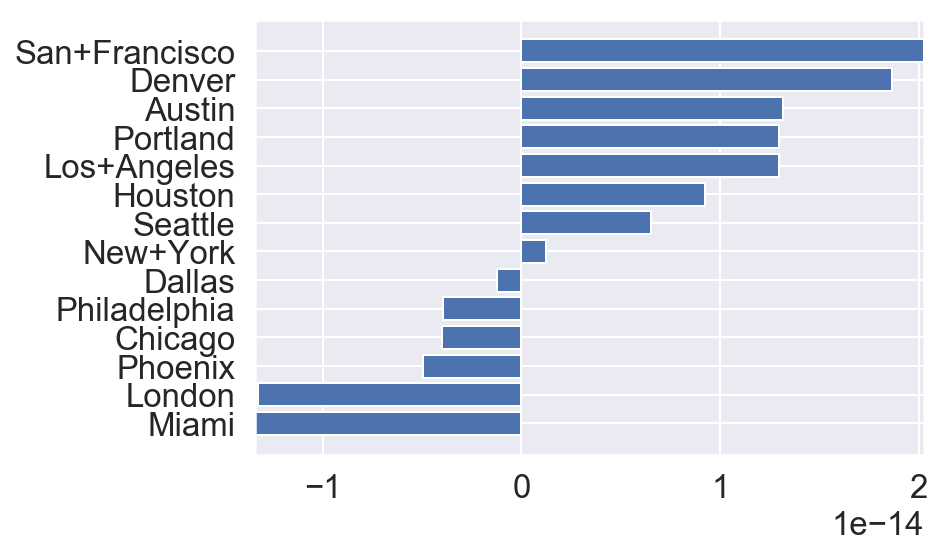

In [388]:
# Display the coefficients/feature importances and write a short summary of what they mean:
import matplotlib.pyplot as plt

location_coef = pd.DataFrame(dict(gs_lrcv_coefficents=best_gs_lrcv.coef_[3]),index=X_dum.columns).sort_values('gs_lrcv_coefficents')
plt.barh(y=location_coef.index, width=location_coef.gs_lrcv_coefficents)

# Ask Chris... why do my coefficents all go to zero? ie. why is the C_ so low??

In [396]:
predictions = best_gs_lrcv.predict(Xs)
print(confusion_matrix(y, predictions))

[[94  1  0  3]
 [74 11  0  1]
 [91  2  0  5]
 [63  2  0 20]]


### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

In [ ]:
## YOUR CODE HERE

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

In [ ]:
## YOUR CODE HERE

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

In [ ]:
## YOUR TEXT HERE IN MARKDOWN FORMAT 

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [ ]:
## YOUR LINK HERE IN MARKDOWN FORMAT 